In [84]:
import re, sys, getopt, os
import os.path
import numpy as np
import matplotlib.pyplot as plt

def strip(pattern,arg):
    m = re.search(pattern, arg)
    return m

def buildCSV(position,arg):
    s=list(arg)
    j=0
    for i in position:
        if j!= 0:
           s.insert(i+j-1,';')
        j=j+1
    return ''.join(s)

def lineType(arg):
    m=strip("Current harvested power",arg)
    if m:
         return "-currentHarvestedPower-"
    m=strip("Current remaining energy",arg)
    if m:
         return "-currentRemainingEnergy-"  
    m=strip("Total energy consumed by radio",arg)
    if m:
        return "-totalEnergyConsumedByRadio-"
    m=strip("Total energy harvested by harvester",arg)
    if m:
        return "-totalEnergyHarvestedByHarvester-"    
    m=strip("Packet sent",arg)
    if m:
        return "-packetSent-"   
    m=strip("Received one packet",arg)
    if m:
        return "-packetReceived-"   
    m=strip("distanceToRx",arg)
    if m:
        return "-distanceToRx-"  
    m=strip("Waf",arg)
    if m:
        return "-waf-"
    return False

def stripWordsFromText(arg):
    return re.sub("[^\w]", " ",  arg).split()

def read_file(arg_in, arg_out):
    if os.path.exists(arg_out):
        os.remove(arg_out)
    fout=open(arg_out,'a+')
    first=True
    lineout=""
    skipline="NO"
    packetSent=0
    packetReceived=0
    distanceToRx=0
    finp= open(arg_in, "r")
    linecsv=""
    for line in finp:
        if not line:
            finp.close()
            #fout.close()
            break
        s=lineType(line)
        #print(line)
        a=0
        b=0
        c=0
        d=0
        e=0
        if s=="-waf-":
            if  first:
                linecsv="timestamp, currentHarvestedPower, currentRemainingEnergy, totalEnergyConsumedByRadio, totalEnergyHarvestedByHarvester"
                fout.write(linecsv+"\n")
                first = False
                
        if s=="-currentHarvestedPower-":
                value=re.findall(r"[-+]?\d*\.\d+|\d+", line)
                linecsv=str(value[0])+", "+str(value[1])+", 0, 0, 0" 
                fout.write(linecsv+"\n")
                
            
        if s=="-currentRemainingEnergy-":
                value=re.findall(r"[-+]?\d*\.\d+|\d+", line)
                linecsv=str(value[0])+", 0, "+str(value[1])+", 0, 0" 
                fout.write(linecsv+"\n")
                
        if s=="-totalEnergyConsumedByRadio-":
                value=re.findall(r"[-+]?\d*\.\d+|\d+", line)           
                linecsv=str(value[0])+", 0, 0, "+str(value[1])+", 0" 
                fout.write(linecsv+"\n")
                
        if s=="-totalEnergyHarvestedByHarvester-":
                value=re.findall(r"[-+]?\d*\.\d+|\d+", line)             
                linecsv=str(value[0])+", 0, 0, 0, "+str(value[1]) 
                fout.write(linecsv+"\n")
        if s=="-packetSent-":
                packetSent = packetSent + 1       
        if s=="-packetReceived-":
                packetReceived = packetReceived + 1 
        if s=="-distanceToRx-":
                value=re.findall(r"[-+]?\d*\.\d+|\d+", line)
                distanceToRx=value[0]
    np.save('test', np.array([packetSent,packetReceived, distanceToRx]))
                
import csv
import math

def make_statistics(arg_in): 
    headers=[]
    first=True
    energy=[]

    with open(arg_in) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if first:
                first=False
                headers=row
            else:
                energy.append(row)
                
        csvfile.close()
    x = np.array(energy)
    energy = x.astype(np.float)
    last=0
    j=0
    for i in np.nditer(energy[:, 4:5]):
        if(i!=0):
            last=energy[j, 4:5]
        else:
            energy[j, 4:5]=last
        j=j+1
        #print(i, end=' ')
    last=0
    j=0
    powerJ=[]
    soma=0
    for i in np.nditer(energy[:, 3:4]):
        if(i!=0):
            last=energy[j, 3:4]
        else:
            energy[j, 3:4]=last
        soma=soma+energy[j, 3:4]
        powerJ=np.append(powerJ,soma)
        j=j+1
        
    #print(powerJ)

    last=0
    j=0

    for i in np.nditer(energy[:, 2:3]):
        if(i!=0):
            last=energy[j, 2:3]
        else:
            energy[j, 2:3]=last
        j=j+1
        #print(i, end=' ')
    #np.save('outfile', energy)
    #print(energy)
    X=energy[:, 0:1]
    Y=energy[:, 4:5]
    Z=energy[:, 3:4]
    #Z=powerJ
    W=energy[:, 2:3]
        #print(X)
        #print(Y)
    k=np.load('test.npy')
    print("Packets Sent = ",k[0], "Packets Received =",k[1],"Packets Lost =",int(k[0])-int(k[1]))
    print("Consumed Energy by WiFi Radio =",round(soma[0],2),"J     Distance Between Nodes = ",k[2], "meters" )
 
    plt.xlabel('Time (s)')
    plt.ylabel('Energy(J)')
    plt.title('Energy Harvested by Harvester And Consumed by Wifi Radio And Current Remaining Energy')
    #fig = plt.figure()
    #ax = plt.subplot(111)
    plt.plot(X, Y, label='Energy Harvested by Harvester')
    plt.plot(X, Y, '-b')
    plt.plot(X, Z, label='Total Energy Consumed By Radio')
    plt.plot(X, Z, '-r')
    plt.plot(X, W, label='Current remaining energy')
    plt.plot(X, W, '-g')
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
 
    # Prints: [8.0, 6.0]
    #print ("Current size:", fig_size)
 
    # Set figure width to 12 and height to 9
    fig_size[0] = 4.5
    fig_size[1] = 3.5
    plt.rcParams["figure.figsize"] = fig_size
    #print ("Current size:", fig_size)
    #chartBox = ax.get_position()
    #chartBox = plt.get_position()
    #plt.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
    #plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    #ax.legend()
    #ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
    #ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    #ax.legend(loc='upper center', bbox_to_anchor=(2.0, 1.0), shadow=True, ncol=1)
    plt.legend(loc='lower right')
    plt.show

Packets Sent =  61 Packets Received = 58 Packets Lost = 3
Consumed Energy by WiFi Radio = 314.02 J     Distance Between Nodes =  300 meters


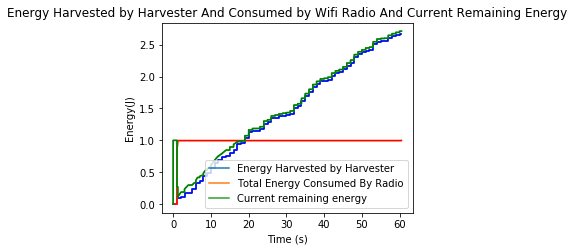

In [87]:
inputfile =  '/home/ubu01/workspace/output300.har'
outputfile = '/home/ubu01/workspace/MO809A_NS3_TrabalhoPratico.out'
    
read_file(inputfile, outputfile)

#inputfile = 'C:\\\\Users\\\\eduar\\\\Documents\\\\2019\\\\UNICAMP\\\\MO809A TOPICOS COMP DIST\\\\Trabalho\\\\Trabalho4_LUXEMBOURG_SCENARIO\\\\MO809A_NS3_TrabalhoPratico.out'
#    
make_statistics(outputfile)

In [47]:
!pwd
!sh -c 'ls'
# Not execute in Jupyter, only in terminal
#!sh -c '/home/ubu01/workspace/bake/source/ns-3.29/waf'
#cd ~/bake/source/ns-3.29
#./waf --run scratch/energy-model-with-harvesting-example &>> /home/ubu01/workspace/
#output.txt
#!cat output.txt

/home/ubu01/workspace
bake					   MO809A_NS3_TrabalhoPratico.out
bin					   outfile.npy
dce					   output200.har
dist_metrics.pxd			   output.har
etc					   output.txt
harv.out				   pyvenv.cfg
hybrid-urban-routing-tutorial-sbrc-master  share
include					   test.npy
lib					   Untitled.ipynb
lib64					   url
MO809A_NS3_TrabalhoPratico_input.txt	   wscript
MO809A_NS3_TrabalhoPratico.ipynb	   xxx.pdf


In [71]:
k=np.load('test.npy')
print(k)
print("Packets Sent = ",k[0], "Packets Received =",k[1],"Packets Lost =", int(k[0])-int(k[1]))

['61' '58' '100']
Packets Sent =  61 Packets Received = 58 Packets Lost = 3
